# Pretrained ML models on Sentinel-2 Images

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.tensorboard import *
import pandas as pd
import os

In [3]:
path = os.getcwd()
path

'/home/jupyter/satellite'

In [4]:
df = pd.read_csv('Level2_labels.csv', header=None, sep='|')
#df1 = df.head(100000)
#df1.head()

In [5]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2)

data = ImageDataBunch.from_df(path,
                              df,
                              folder='../data/rgb',suffix='.png',
                              label_delim=';',
                              bs=256,
                              seed=42,
                              valid_pct=0.2,
                              ds_tfms=tfms,
                              size=120).normalize(imagenet_stats)

In [6]:
#data.show_batch(rows=2, figsize=(5,5))

In [7]:
# Tensorboard save location
project_id = 'Level2'
tboard_path = Path('tensorboard/' + project_id)

# Metrics
acc_02 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)
#mult_fbeta = partial(MultiLabelFbeta, average='weighted', thresh=0.4)

# Create cnn with the resnet50 architecture
learner = cnn_learner(data, models.resnet50, metrics=[acc_02,f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


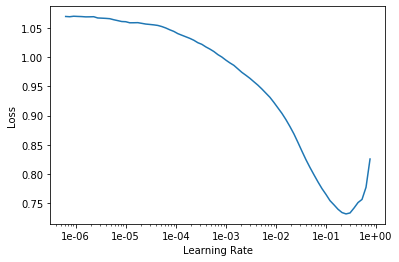

In [7]:
learner.lr_find()
learner.recorder.plot()

In [8]:
lr = 1e-2

In [9]:
#Add callback_fns to Learner for logging
#learner.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=tboard_path, name='CNNLearner'))
learner.callback_fns.append(partial(CSVLogger,filename='Level2', append=True))
learner.callback_fns.append(ShowGraph)

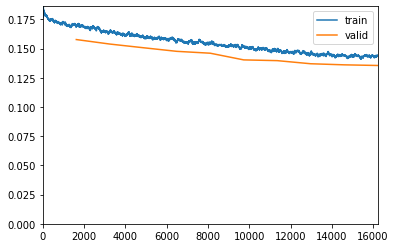

In [11]:
learner.fit_one_cycle(10, slice(lr))

In [12]:
learner.save('Level2_stage-1-rn50')

In [15]:
#learner.summary()

In [10]:
learner.load('Level2_stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Arable land;Heterogeneous agricultural areas;Pastures;Forests,Scrub and/or herbaceous vegetation associations;Forests,Forests;Urban fabric;Heterogeneous agricultural areas,Pastures;Forests,Inland waters;Forests
Path: /home/jupyter/satellite;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Pastures;Mine, dump and construction sites,Marine waters,Urban fabric;Heterogeneous agricultural areas,Scrub and/or herbaceous vegetation associations;Inland wetlands;Forests,Scrub and/or herbaceous vegetation associations;Pastures;Forests
Path: /home/jupyter/satellite;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), 

In [8]:
#learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [11]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


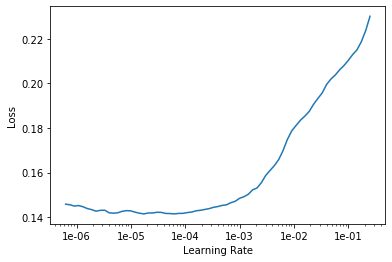

In [12]:
learner.lr_find()
learner.recorder.plot()

In [13]:
lr = 1e-5

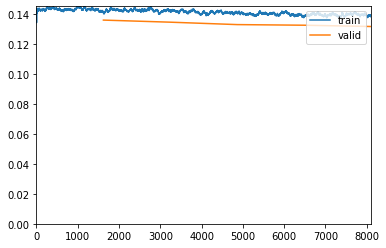

In [14]:
learner.fit_one_cycle(5, slice(lr, lr/5))

In [15]:
learner.save('Level2-stage-2-rn50')

In [17]:
#learner.load('Level2-stage-2-rn50')

In [16]:
torch.save(learner.model[0].state_dict(), 'models/Level2_stage-2-rn50.h5')

### Analysis

In [17]:
#interp = ClassificationInterpretation.from_learner(learner)
interp = learner.interpret()

In [9]:
#losses,idxs = interp.top_losses(data.c)

#len(data.valid_ds)==len(losses)==len(idxs)

In [10]:
#len(data.valid_ds),len(losses), len(idxs)

In [11]:
#idxs

In [14]:
#interp.plot_multi_top_losses??

2148 misclassified samples over 103867 samples in the validation set.


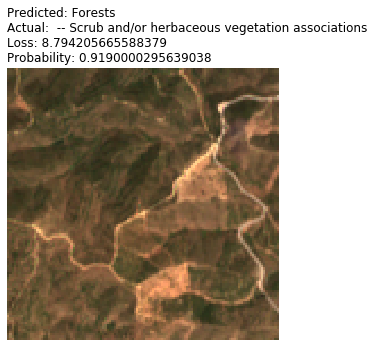

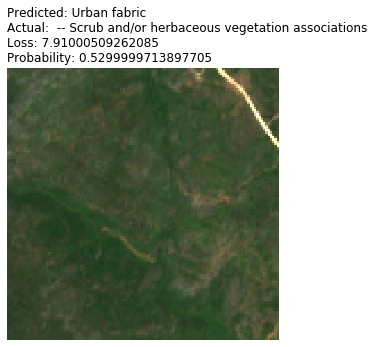

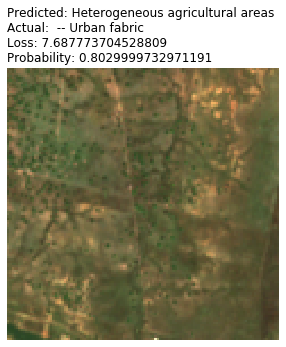

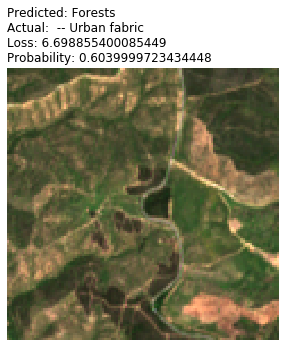

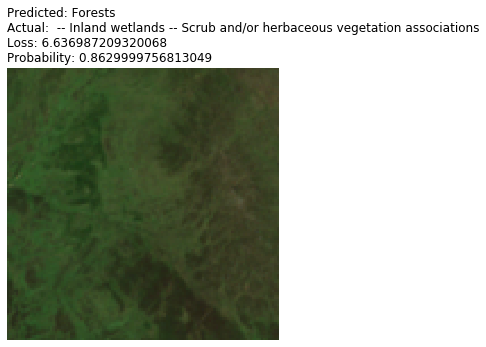

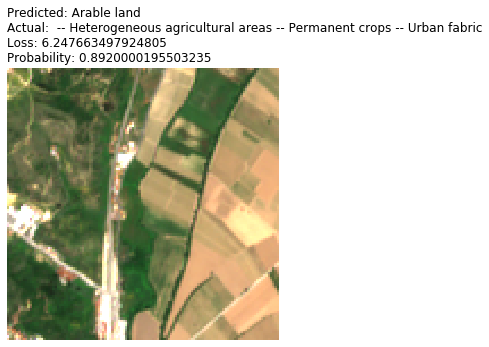

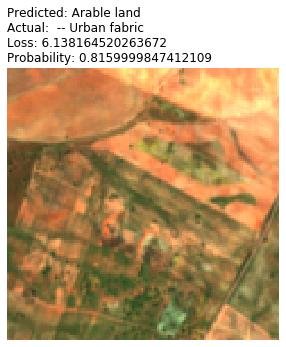

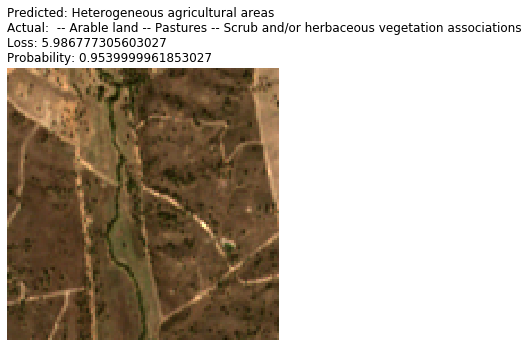

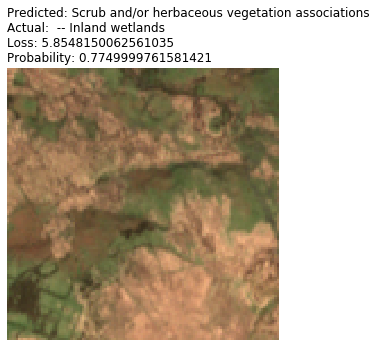

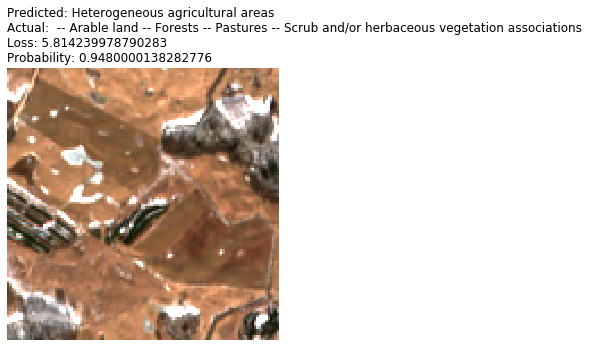

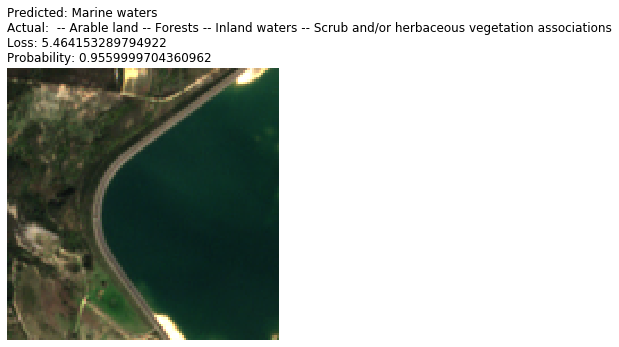

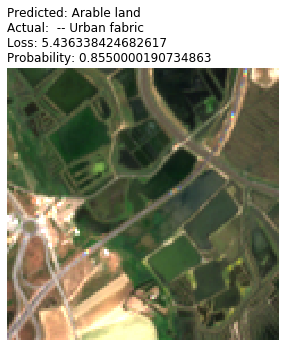

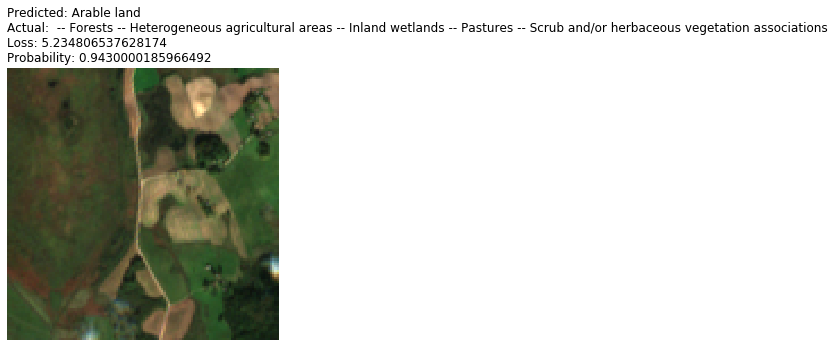

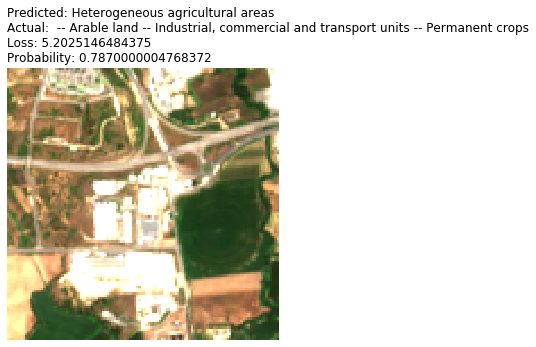

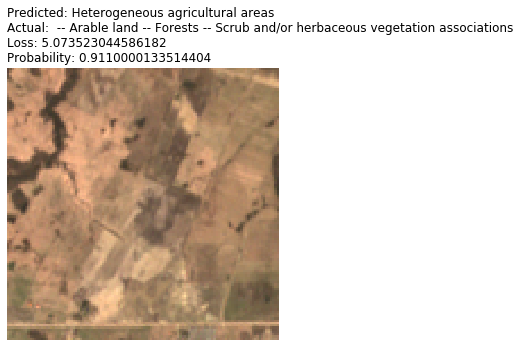

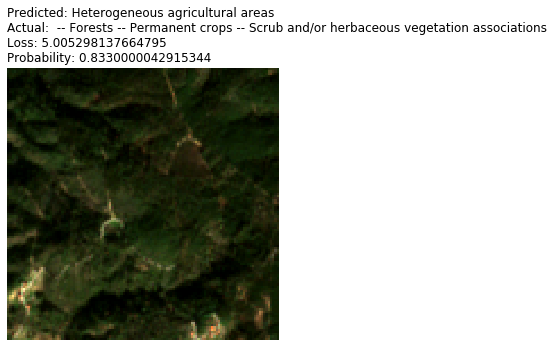

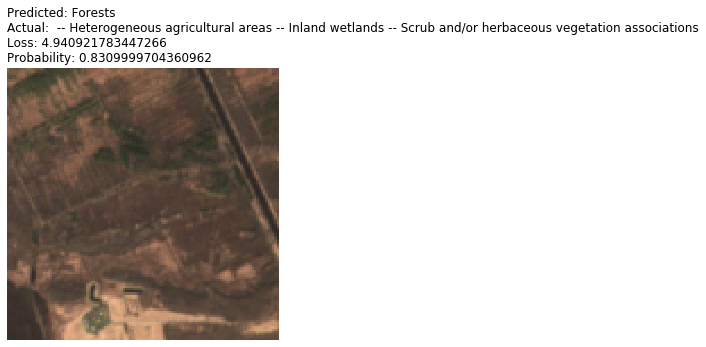

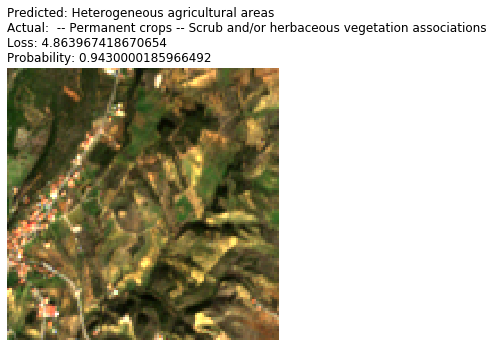

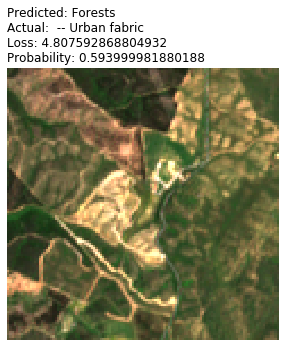

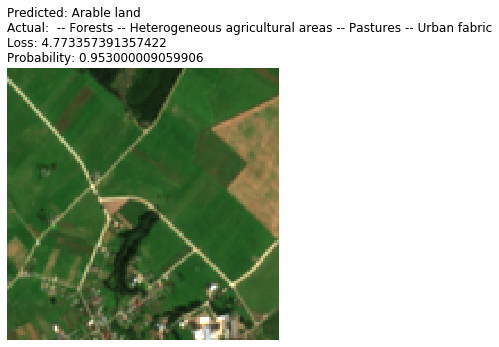

In [18]:
#misclassifieds = interp.plot_multi_top_losses(9, figsize=(5,5), save_misclassified=True)
interp.plot_multi_top_losses(20, figsize=(5,5))

In [13]:
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes

In [159]:
len(misclassifieds)

5170

In [14]:
data.classes

['Agro-forestry areas',
 'Airports',
 'Annual crops associated with permanent crops',
 'Bare rock',
 'Beaches, dunes, sands',
 'Broad-leaved forest',
 'Burnt areas',
 'Coastal lagoons',
 'Complex cultivation patterns',
 'Coniferous forest',
 'Construction sites',
 'Continuous urban fabric',
 'Discontinuous urban fabric',
 'Dump sites',
 'Estuaries',
 'Fruit trees and berry plantations',
 'Green urban areas',
 'Industrial or commercial units',
 'Inland marshes',
 'Intertidal flats',
 'Land principally occupied by agriculture, with significant areas of natural vegetation',
 'Mineral extraction sites',
 'Mixed forest',
 'Moors and heathland',
 'Natural grassland',
 'Non-irrigated arable land',
 'Olive groves',
 'Pastures',
 'Peatbogs',
 'Permanently irrigated land',
 'Port areas',
 'Rice fields',
 'Road and rail networks and associated land',
 'Salines',
 'Salt marshes',
 'Sclerophyllous vegetation',
 'Sea and ocean',
 'Sparsely vegetated areas',
 'Sport and leisure facilities',
 'Transit

#### Following code from
#### https://dhruvs.space/posts/grad-cam-heatmaps-along-resnet-34/

class name: Discontinuous urban fabric;Non-irrigated arable land
class_index: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


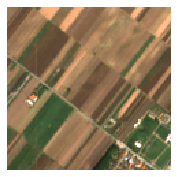

In [196]:
idx=33
x,y = data.valid_ds[idx]
x.show()
print(f'class name: {y}\nclass_index: {y.data}')

In [197]:
learner.predict(x)[0]

MultiCategory Discontinuous urban fabric;Non-irrigated arable land

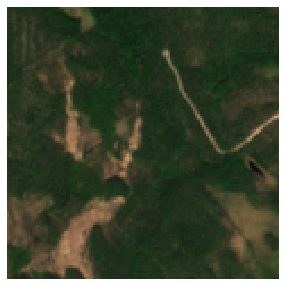

In [120]:
x.show(figsize=(5,5))

In [121]:
x.shape

torch.Size([3, 120, 120])

In [122]:
from fastai.callbacks.hooks import *

In [123]:
m = learner.model.eval();

In [124]:
xb,_ = data.one_item(x)    #get tensor from Image x
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [125]:
def non_class_discriminative_activations_multi(xb):
    hooks = []
    layer_names = []
    
    hooks.append(hook_output(m[0][3]))
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learner.model[0][ind]):
            hooks.append(hook_output(el))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    
    for hook in hooks:
        hook.remove()
    
    return hooks,layer_names

In [126]:
hooks,layer_names = non_class_discriminative_activations_multi(xb)

In [127]:
for layer_name,hook in zip(layer_names,hooks):
    print(f'{layer_name}{" "*(18-len(layer_name))} -->   {hook.stored[0].shape}')

first conv         -->   torch.Size([64, 30, 30])
layer-1 - conv-1   -->   torch.Size([256, 30, 30])
layer-1 - conv-2   -->   torch.Size([256, 30, 30])
layer-1 - conv-3   -->   torch.Size([256, 30, 30])
layer-2 - conv-1   -->   torch.Size([512, 15, 15])
layer-2 - conv-2   -->   torch.Size([512, 15, 15])
layer-2 - conv-3   -->   torch.Size([512, 15, 15])
layer-2 - conv-4   -->   torch.Size([512, 15, 15])
layer-3 - conv-1   -->   torch.Size([1024, 8, 8])
layer-3 - conv-2   -->   torch.Size([1024, 8, 8])
layer-3 - conv-3   -->   torch.Size([1024, 8, 8])
layer-3 - conv-4   -->   torch.Size([1024, 8, 8])
layer-3 - conv-5   -->   torch.Size([1024, 8, 8])
layer-3 - conv-6   -->   torch.Size([1024, 8, 8])
layer-4 - conv-1   -->   torch.Size([2048, 4, 4])
layer-4 - conv-2   -->   torch.Size([2048, 4, 4])
layer-4 - conv-3   -->   torch.Size([2048, 4, 4])


In [128]:
acts  = hook.stored[0].cpu()
acts.shape

torch.Size([2048, 4, 4])

In [129]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([4, 4])

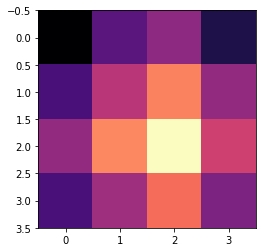

In [130]:
plt.imshow(avg_acts, cmap='magma');

In [131]:
from math import ceil

In [132]:
def plot_forward_activations_multi(hooks):
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            ax[i,j].imshow(avg_acts, cmap='magma')
            ind+=1
            
    plt.show()

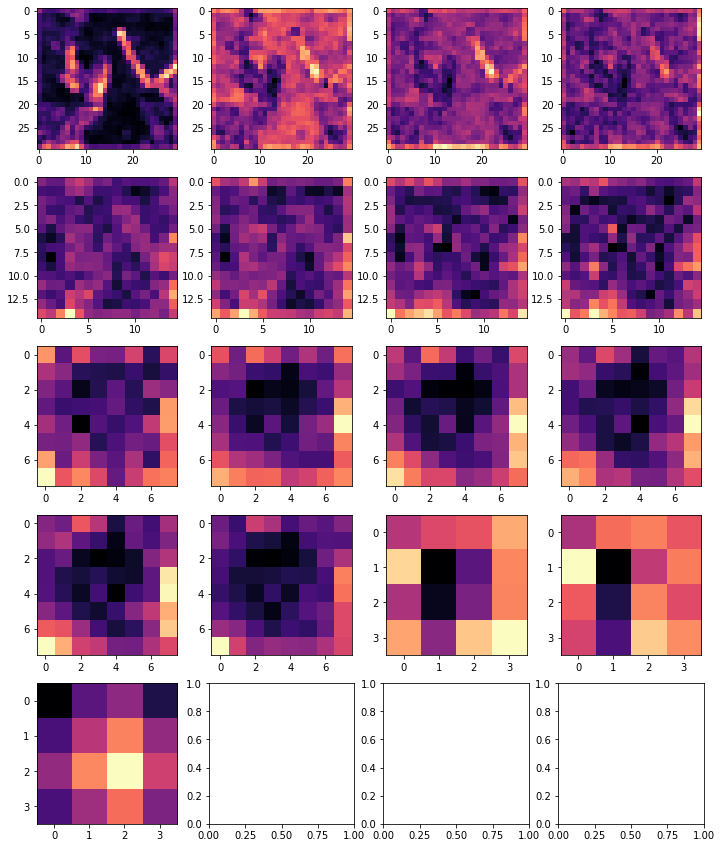

In [133]:
plot_forward_activations_multi(hooks)

In [134]:
def plot_non_class_discriminative_heatmaps_multi(x):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    hooks,_ = non_class_discriminative_activations_multi(xb)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(avg_acts, alpha=0.6, extent=(0,120,120,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

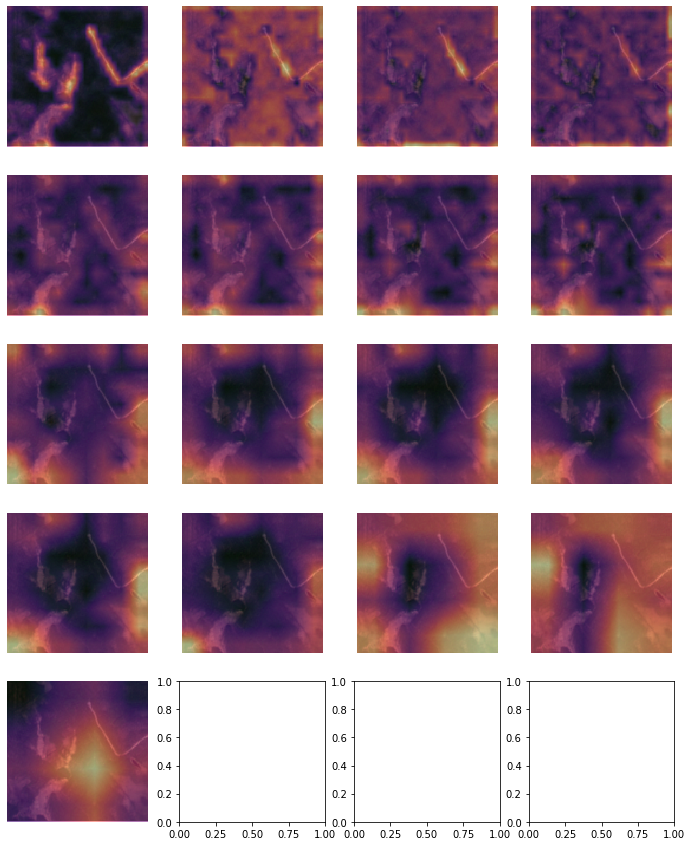

In [135]:
plot_non_class_discriminative_heatmaps_multi(x)

In [136]:
def class_discriminative_gradients_multi(xb, cat):
    hooks_a = []
    hooks_g = []
    layer_names = []
    
    hooks_a.append(hook_output(m[0][3]))
    hooks_g.append(hook_output(m[0][3], grad=True))
    
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learner.model[0][ind]):
            hooks_a.append(hook_output(el))
            hooks_g.append(hook_output(el, grad=True))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    preds[0,int(cat)].backward()
    
    for hook in hooks_a:
        hook.remove()
        
    for hook in hooks_g:
        hook.remove()
    
    return hooks_a,hooks_g,layer_names

In [137]:
def plot_class_discriminative_heatmaps_multi(x,cat=None,relu=True):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    if cat is None:
        y_to_get_gradients_for = y.data
    else:
        y_to_get_gradients_for = cat
    
    hooks_a,hooks_g,_ = class_discriminative_gradients_multi(xb,y_to_get_gradients_for)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts = hooks_a[ind].stored[0].cpu()
            grad = hooks_g[ind].stored[0][0].cpu()

            grad_chan = grad.mean(1).mean(1)
            mult = (acts*grad_chan[...,None,None]).mean(0)

            if relu:
                mult = F.relu(mult)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,120,120,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

In [138]:
def plot_classwise_discriminative_heatmaps_multi(x,cat,relu=True):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    y_to_get_gradients_for = cat
    #print(len(cat))
    num_cols = len(y_to_get_gradients_for)
    num_rows = len(hooks)
    ind = 0   
    for i in y_to_get_gradients_for:
        print(i)
    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)
    
    for i in range(num_rows):
        for j in range(num_cols):
            hooks_a,hooks_g,_ = class_discriminative_gradients_multi(xb,class_dict[y_to_get_gradients_for[j]])

            if ind >= len(hooks):
                break

            acts = hooks_a[ind].stored[0].cpu()
            grad = hooks_g[ind].stored[0][0].cpu()

            grad_chan = grad.mean(1).mean(1)
            mult = (acts*grad_chan[...,None,None]).mean(0)

            if relu:
                mult = F.relu(mult)
            #print(y_to_get_gradients_for[j])
            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,120,120,0),
                      interpolation='bilinear', cmap='magma');
        ind+=1

    plt.show()

In [139]:
#data.classes

In [140]:
datClasses = np.asarray(data.classes)

In [141]:
y.data.astype(int)==1

array([False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False])

In [142]:
catso = np.char.lower(datClasses[y.data.astype(int)==1])

In [143]:
for i in catso:
    print(i)

coniferous forest
mixed forest


In [144]:
#plot_class_discriminative_heatmaps_multi(x)

In [145]:
class_dict = {}
for i,el in enumerate(data.classes):
    class_dict[el.lower()] = i

In [146]:
learner.predict(x)[0]

MultiCategory Coniferous forest;Mixed forest

coniferous forest
mixed forest


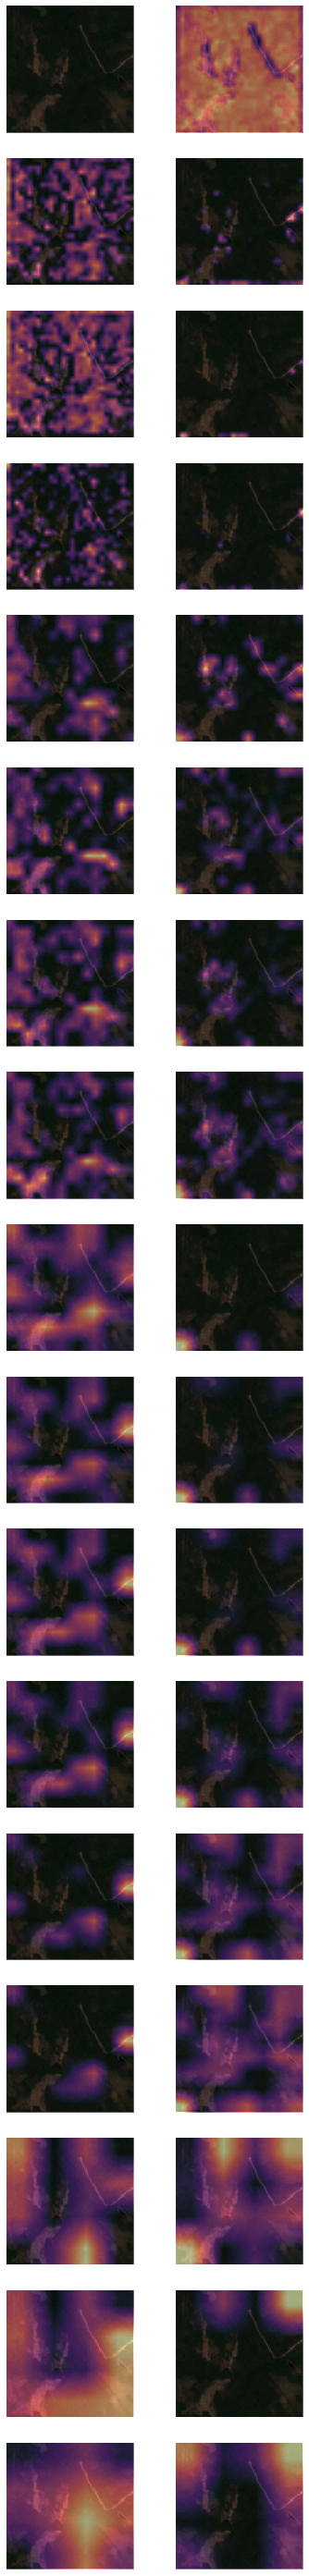

In [147]:
plot_classwise_discriminative_heatmaps_multi(x,catso)

In [149]:
class_dict['coniferous forest']

9

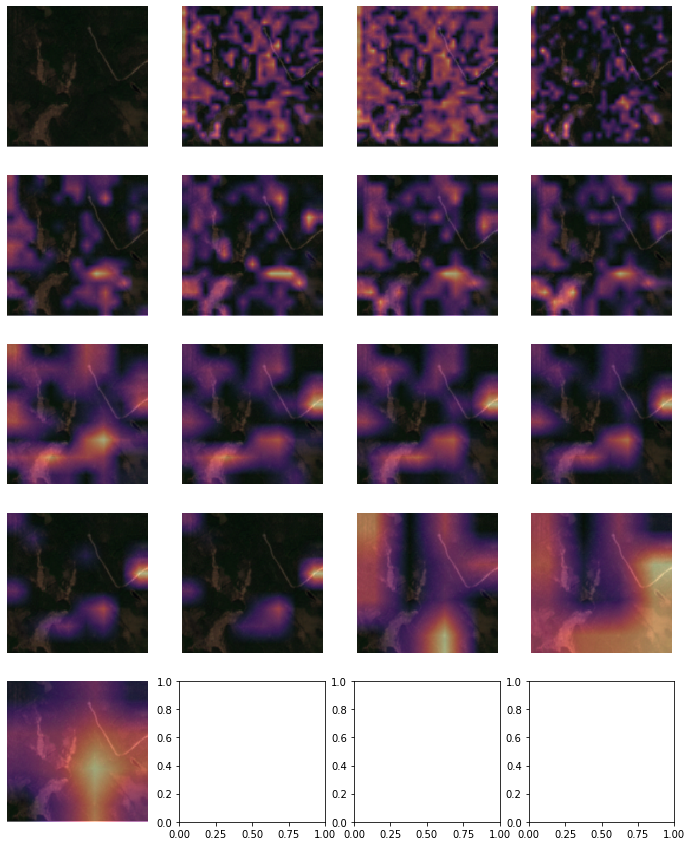

In [150]:
plot_class_discriminative_heatmaps_multi(x,class_dict['coniferous forest'])

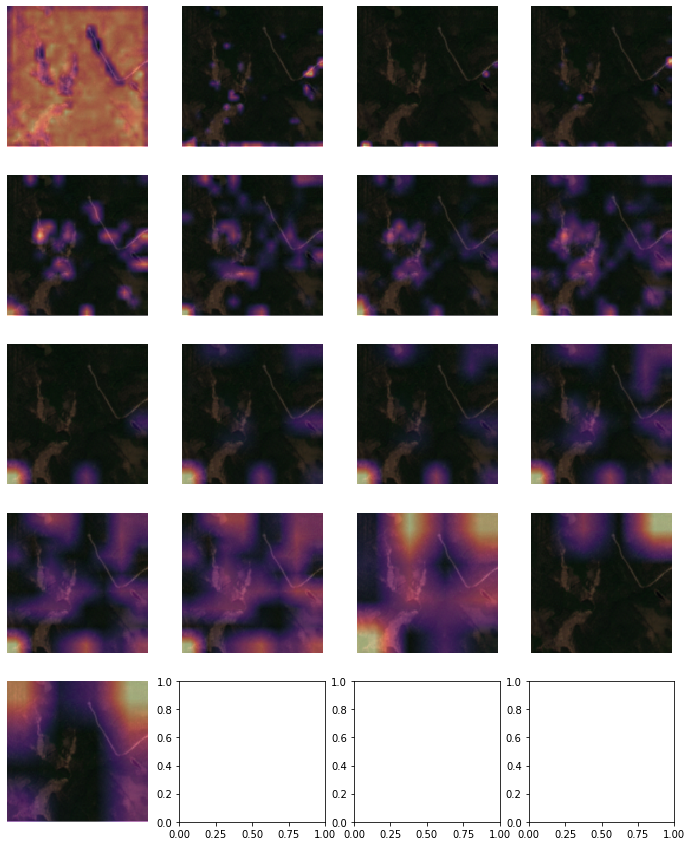

In [151]:
plot_class_discriminative_heatmaps_multi(x,class_dict['mixed forest'])

In [152]:
#plot_class_discriminative_heatmaps_multi(x,class_dict['water bodies'])

In [153]:
y.data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# ResNet152

In [4]:
tfms = get_transforms(do_flip=True,flip_vert=True, max_lighting=0.2)
data = ImageDataBunch.from_csv(path, folder='../data/rgb',csv_labels='rgbLabels.csv',suffix='.png', delimiter='|',label_delim=';', header=None,bs=128, valid_pct=0.2,ds_tfms=tfms, size=120).normalize(imagenet_stats)

In [5]:
# create metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
# create cnn with the resnet50 architecture
#learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learner = cnn_learner(data, models.resnet152, metrics=[acc_02,f_score])

In [6]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


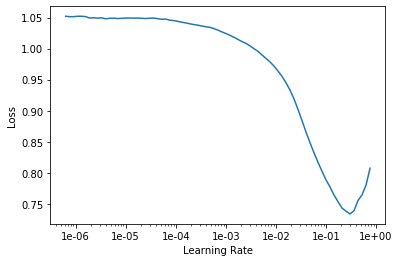

In [7]:
learner.recorder.plot()

In [8]:
lr = 0.04

In [9]:
learner.fit_one_cycle(5, slice(lr))

In [10]:
learner.save('stage-1-rn152')